In [7]:
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from gym_trading_env.downloader import download
import pandas_ta as ta

<Axes: xlabel='date_open'>

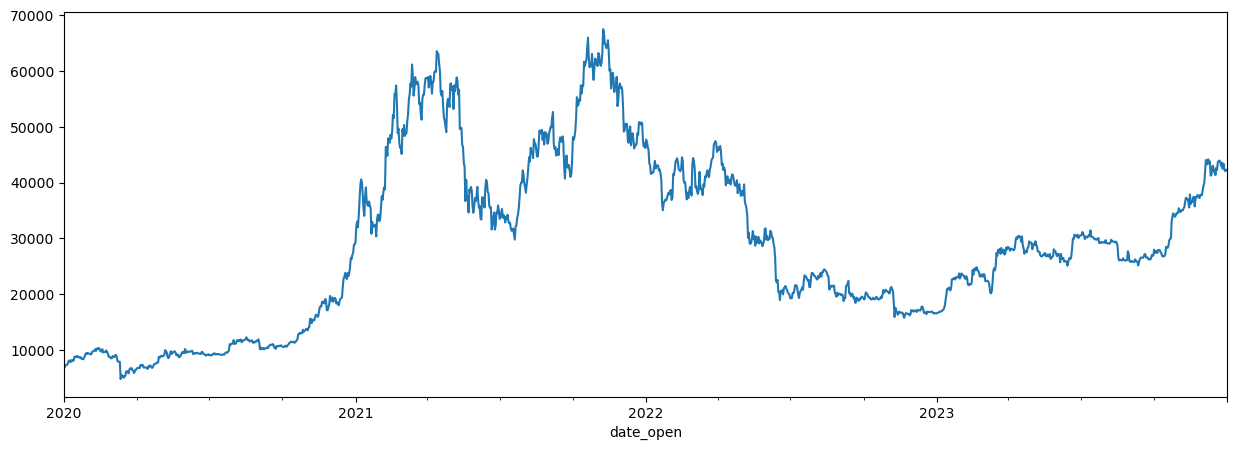

In [8]:
# Download BTC/USDT historical data from Binance and stores it to directory ./data/binance-BTCUSDT-1h.pkl
# download(exchange_names = ["binance"],
#     symbols= ["BTC/USDT"],
#     timeframe= "1d",
#     dir = "data",
#     since= datetime.datetime(year= 2019, month= 12, day=31),
#     until= datetime.datetime(year= 2024, month= 1, day=1)
# )
# Import your fresh data
df = pd.read_pickle("./data/binance-BTCUSDT-1d.pkl")
df["close"].plot(figsize=(15, 5))

<Axes: xlabel='date_open'>

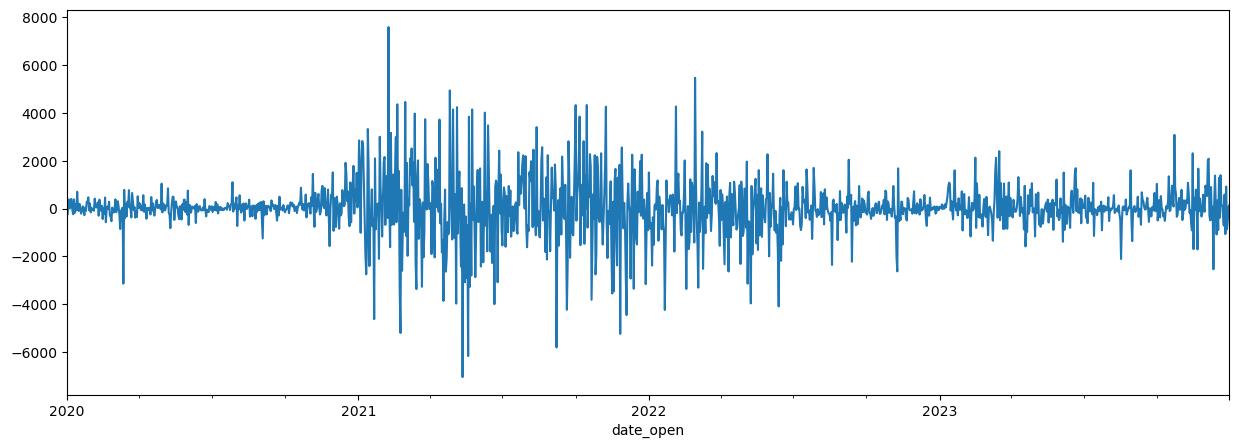

In [10]:
ret = df.close.diff()
ret.plot(figsize=(15, 5))

In [12]:
adfuller_test = adfuller(ret.dropna())
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -12.098063946075985
p-value: 2.0485699318253287e-22
Is the spread stationary? Yes


In [13]:
import gymnasium as gym
import gym_trading_env

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    stationaryDGP, 
    nonstationaryDGP, 
    # build_features, 
    # build_rolling_feature
    FeatureEngineering
)

In [17]:
# build features
train_size = 0.8
df_train = df.copy().iloc[:int(len(df)*train_size)]
df_test = df.copy().iloc[int(len(df)*train_size):]

feature_config = {
    "window": 1, # 7 days window, pad with first value when window is not available
    "mode": "diff" # difference between current and previous close price
}

fe = FeatureEngineering(df_train, main_feature_col="close")
fe.rolling_feature(**feature_config)
df_train = fe.df.copy()

fe = FeatureEngineering(df_test, main_feature_col="close")
fe.rolling_feature(**feature_config)
df_test = fe.df.copy()

In [18]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[0. 0. 0.]
Market Return : 116.50%   |   Portfolio Return : -116.50%   |   Position Changes : 1   |   Episode Length : 310   |   


In [23]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=6, replay_every=2)

Market Return : 234.87%   |   Portfolio Return : 297.19%   |   Position Changes : 754   |   Episode Length : 1168   |   
Market Return : 234.87%   |   Portfolio Return : -88.91%   |   Position Changes : 783   |   Episode Length : 1168   |   
Market Return : 234.87%   |   Portfolio Return : 249.26%   |   Position Changes : 713   |   Episode Length : 1168   |   
Market Return : 234.87%   |   Portfolio Return : 192.69%   |   Position Changes : 749   |   Episode Length : 1168   |   
Market Return : 234.87%   |   Portfolio Return : 757.64%   |   Position Changes : 723   |   Episode Length : 1168   |   
Market Return : 234.87%   |   Portfolio Return : 1270.30%   |   Position Changes : 741   |   Episode Length : 1168   |   


In [25]:
env_test = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_test, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
    )
env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

env_test = agent.eval(env_test)

Market Return : 71.39%   |   Portfolio Return : -7.90%   |   Position Changes : 179   |   Episode Length : 293   |   
